# **Neutrino Oscillation with DUNE** ($\delta_{cp}$)

## PHYS591000 Physics AI Final Project

This is the project implementing ML to find out the $\Theta_{13}$ and $\delta_{cp}$ using the neutrino data from DUNE experiment.  
Original link: [Kaggle](https://www.kaggle.com/competitions/phys591000-2023-final-project-i)

> Author(s): Siang-Yuan Lin, Yuan-Yen Peng  
> Email(s) : sylin@gapp.nthu.edu.tw, garyphys0915@gapp.nthu.edu.tw  
> Licence : MIT  
> Data : May, 2023


### prerequisites

1. reset all varialbes
2. import curcial modules
3. mount google drive
4. check the GPU is on


In [32]:
# clear all variables
%reset -f

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [33]:
import gc
import numpy as np
import scipy
import matplotlib.pyplot as plt

from numba import njit  # acceleration kernel
import tensorflow as tf


In [34]:
# check the tensorflow and GPU

print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


Using Tensorflow 2.9.0
Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
# import the datasets and check the files

path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
# path = "/kaggle/input/phys591000-2023-final-project-i/"# Kaggle
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print("-> The file is", filename)
if not os.path.isfile(
    path + "neutrino_training_data.npz"
    ):
    raise FileNotFoundError("test/train data was not found or is a directory")

./phys591000-2023-final-project/neutrino_test_data.npz
-> The file is neutrino_test_data.npz
./phys591000-2023-final-project/neutrino_training_data.npz
-> The file is neutrino_training_data.npz


In [36]:
%%time
# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
# data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
# name_test = data_test.files

print(f"Train: {name_train}")
# print(f"Test : {name_test}")

ve_train, vebar_train, vu_train, vubar_train, theta23_train, delta_train, ldm_train = map(lambda n: data_train[n], name_train)
# ve_test, vebar_test, vu_test, vubar_test = map(lambda n: data_test[n], name_test)

Train: ['ve', 'vebar', 'vu', 'vubar', 'theta23', 'delta', 'ldm']
CPU times: user 13.9 s, sys: 787 ms, total: 14.6 s
Wall time: 15.2 s


In [37]:
# check the data shape

print(
    f"""# TRAIN
ve_train     :{ve_train.shape}
vebar_train  :{vebar_train.shape}
vu_train     :{vu_train.shape}
vubar_train  :{vubar_train.shape}
theta23_train:{theta23_train.shape}
delta_train  :{delta_train.shape}
ldm_train    :{ldm_train.shape}
"""
)


# TRAIN
ve_train     :(1000000, 65)
vebar_train  :(1000000, 65)
vu_train     :(1000000, 65)
vubar_train  :(1000000, 65)
theta23_train:(1000000,)
delta_train  :(1000000,)
ldm_train    :(1000000,)



In [38]:
# create train and test data
X_train = np.stack((ve_train, vebar_train, vu_train, vubar_train), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
# X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

print(
    f"""
The shape of x_train: {X_train.shape}
The shape of y_train: {Y_train.shape}
"""
)


The shape of x_train: (1000000, 65, 4)
The shape of y_train: (1000000, 3)



In [39]:
# # define plotting functions


# def four_plot(data_format: list) -> None:
#     train, test = data_format
#     bins = np.arange(0.625, 8 + 0.125, 0.125)
#     name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]

#     fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=80, constrained_layout=True)
#     fig.suptitle("First 60 features")
#     for i, (train_data, test_data, name) in enumerate(zip(train, test, name)):
#         ax = axes[i // 2, i % 2]
#         ax.set_title(name)
#         ax.step(bins, train_data[:60], label="train")
#         ax.step(bins, test_data[:60], label="test")
#         ax.legend(loc="best")
#         ax.set_xlabel("Energy E [GeV]")
#         ax.set_ylabel(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")

#     plt.show()
#     print("Success to plot")
#     plt.close()
#     return


# def four_2d_plot(data_format: list) -> None:
#     name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]
#     vmin = min(np.min(data_format[0]), np.min(data_format[1]))
#     vmax = max(np.max(data_format[0]), np.max(data_format[1]))
#     dataset_name = ["train", "test"]
#     fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=80, constrained_layout=True)
#     fig.suptitle("First 60 features")
#     for i, data in enumerate(data_format):
#         ax = axes[i]
#         im = ax.imshow(data.T, origin="lower")
#         ax.set_title(dataset_name[i])
#         ax.set_xlabel("Energy E [GeV]")
#         ax.set_yticks(np.arange(4))
#         ax.set_yticklabels(name)
#         im.set_clim(vmin, vmax)
#     cbar = fig.colorbar(im, ax=axes, location="bottom", aspect=25, pad=0.1)
#     cbar.ax.set_title(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")
#     plt.show()
#     print("Success to plot")
#     plt.close()
#     return


In [40]:
# # inspect data structures

# # check ``1D images''
# train_10 = [ve_train[10], vebar_train[10], vu_train[10], vubar_train[10]]
# test_10 = [ve_test[10], vebar_test[10], vu_test[10], vubar_test[10]]
# train_average = [
#     np.average(ve_train, axis=0),
#     np.average(vebar_train, axis=0),
#     np.average(vu_train, axis=0),
#     np.average(vubar_train, axis=0),
# ]
# test_average = [
#     np.average(ve_test, axis=0),
#     np.average(vebar_test, axis=0),
#     np.average(vu_test, axis=0),
#     np.average(vubar_test, axis=0),
# ]
# data_format = [train_10, test_10]
# data_sum_format = [train_average, test_average]
# four_plot(data_format)
# four_plot(data_sum_format)

# # check ``2D images''
# for i in [9, 99, 999]:
#     data_format = [X_train[i, 0:60, :], X_test[i, 0:60, :]]
# #     four_2d_plot(data_format)


In [41]:
# # check theta and delta relations

# fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=100, constrained_layout=True)
# for i, name in enumerate([r"$\Theta_{13}$ [rad]", r"$\delta_{cp}$ [rad]"]):
#     print(
#         f"""The max of {name} is {np.max(Y_train[:, i])};
# The min of {name} is {np.min(Y_train[:, i])};
# The avg of {name} is {np.average(Y_train[:, i])}.
# """
#     )
#     ax = axes[i]
#     n = 100
#     ax.bar(np.arange(n), Y_train[:n, i], width=0.1)
#     ax.set_title(f"First 100 features of {name}")
#     ax.set_xlabel("order of features")
#     ax.set_ylabel("Values [unit]")
# plt.show()
# plt.close()


In [42]:
train_normal = X_train[ldm_train > 0]
train_invert = X_train[ldm_train < 0]
theta23_normal = theta23_train[ldm_train > 0]
theta23_invert = theta23_train[ldm_train < 0]
delta_normal = delta_train[ldm_train > 0]
delta_invert = delta_train[ldm_train < 0]


def norm_alg(input_data: np.ndarray) -> np.ndarray:
    data_max = np.max(input_data, axis=0)
    offset = np.min(input_data, axis=0)
    scale = data_max - offset
    input_data = (input_data - offset) / scale
    return input_data


# normalize labels to [0,1]
ldm_train_norm = norm_alg(ldm_train)
theta23_NH_norm = norm_alg(theta23_normal)
theta23_IH_norm = norm_alg(theta23_invert)
delta_NH_norm = norm_alg(delta_normal)
delta_IH_norm = norm_alg(delta_invert)

# normalize training data to [0,1]
MAX_X = np.max(X_train)
MIN_X = np.min(X_train)
train_NH_norm = (train_normal - MIN_X) / (MAX_X - MIN_X)
train_IH_norm = (train_invert - MIN_X) / (MAX_X - MIN_X)
labeling = np.where(ldm_train > 0, 1, 0)

"""
[Train X] normalize training data to [0,1]
"""
x_train_NH = X_train[ldm_train > 0]
MAX_X = np.max(x_train_NH)
MIN_X = np.min(x_train_NH)
x_train_NH_norm = (x_train_NH - MIN_X) / (MAX_X - MIN_X)
print("Finish training data...")


"""
[Train Y] normalize training label to [0,1]
"""
# choose delta_cp {1}
y_train_NH = Y_train[:, 1][ldm_train > 0]
MAX_Y = np.max(y_train_NH)
MIN_Y = np.min(y_train_NH)
y_train_NH_norm_sin = np.sin(y_train_NH * np.pi / 180)  # degree -> rad [sin]
y_train_NH_norm_ang = np.pi * (y_train_NH - 180) / 180  # degree -> rad [-pi, pi]
print("Finish training labels...")

Finish training data...
Finish training labels...


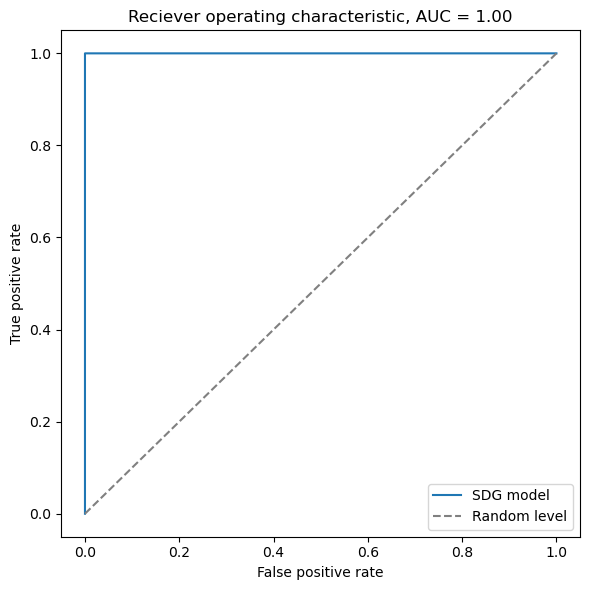

3756

In [43]:
# pre-classification for the mass hierachy
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

ldm_class = SGDClassifier(max_iter=1000, tol=1e-3)
ldm_class.fit(X_train[:, :, 0], labeling)
train_predict = ldm_class.predict(X_train[:, :, 0])

fpr, tpr, thresholds = metrics.roc_curve(labeling, train_predict, pos_label=1)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="SDG model")
plt.plot([0, 1], [0, 1], label="Random level", ls="dashed", c="Grey")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(
    "Reciever operating characteristic, AUC = {:.2f}".format(metrics.auc(fpr, tpr))
)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# clear unused variables
del ldm_class
del (
    train_normal,
    train_invert,
    theta23_normal,
    theta23_invert,
    delta_normal,
    delta_invert,
)
del (
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
    # ve_test,
    # vebar_test,
    # vu_test,
    # vubar_test,
)
del X_train, Y_train
gc.collect()

In [44]:
# create validation data
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2
tf.random.set_seed(2023)
x_train_reg, x_val_reg, y_train_reg, y_val_reg = train_test_split(
    x_train_NH_norm, y_train_NH_norm_sin, test_size=0.2, shuffle=True, random_state=10
)
print(
    f"""# sin set
The shape of x_train     : {x_train_reg.shape}
The shape of y_train     : {y_train_reg.shape}
The shape of x_validation: {x_val_reg.shape}
The shape of y_validation: {y_val_reg.shape}
"""
)

# sin set
The shape of x_train     : (400021, 65, 4)
The shape of y_train     : (400021,)
The shape of x_validation: (100006, 65, 4)
The shape of y_validation: (100006,)



In [45]:
# create validation data

# split the training dataset into training and validation, with test_size = 0.2
x_train_cla, x_val_cla, y_train_cla, y_val_cla = train_test_split(
    x_train_NH_norm, y_train_NH_norm_ang, test_size=0.2, shuffle=True, random_state=10
)
print(
    f"""# delta set
The shape of x_train     : {x_train_cla.shape}
The shape of y_train     : {y_train_cla.shape}
The shape of x_validation: {x_val_cla.shape}
The shape of y_validation: {y_val_cla.shape}
"""
)

del x_train_NH_norm

# delta set
The shape of x_train     : (400021, 65, 4)
The shape of y_train     : (400021,)
The shape of x_validation: (100006, 65, 4)
The shape of y_validation: (100006,)



In [47]:
# load small_vgg (with norm data) and do the analysis
regression = tf.keras.models.load_model(
    "./model/cp_phase/regression/regression.h5", compile=False
)
classfication = tf.keras.models.load_model(
    "./model/cp_phase/classification/classification.h5", compile=False
)

# validation checking
x_val_pred_sin = regression.predict(x_val_reg)
x_val_pred_ang = classfication.predict(x_val_cla)

3126/3126 [==============================] - 10s 3ms/step


In [48]:
from sklearn.metrics import mean_squared_error


def analysis(x_train_pred: np.ndarray, y_train: np.ndarray) -> None:
    # set statistical parameters
    n = len(x_train_pred)
    dof = n - 2
    t = scipy.stats.t.ppf(0.975, dof)

    # linear fitting line
    slope, intercept = np.polyfit(x_train_pred, y_train, 1)
    slope, intercept, r, p, se = scipy.stats.linregress(x_train_pred, y_train)
    plt_min = np.min([np.min(x_train_pred), np.min(y_train)])
    plt_max = np.max([np.max(x_train_pred), np.max(y_train)])
    x_line = np.linspace(plt_min, plt_max, 100)
    y_line = np.polyval([slope, intercept], x_line)

    # acceleration kernel (to calculate mse, confident level, and prediction level)
    @njit(parallel=False, fastmath=True)
    def mse_kernel(pred, true, t_value=t, n=n, dof=dof, x_line=x_line, y_line=y_line):
        if true.shape != pred.shape:
            raise ValueError("True/Pred data should be the same shape!")
        mse = np.empty(len(true))
        for ind, (t, p) in enumerate(zip(true, pred)):
            mse[ind] = np.average(np.square(t - p))
        pred_mean = np.average(x_train_pred)
        sum_se = np.sum(np.square(true - pred))
        std_error = np.sqrt(1 / dof * sum_se)
        # confidence interval
        ci = (
            t_value
            * std_error
            * np.sqrt(
                1 / n
                + np.square(x_line - pred_mean)
                / np.sum(np.square(x_train_pred - pred_mean))
            )
        )
        # predicting interval
        pi = (
            t_value
            * std_error
            * np.sqrt(
                1
                + 1 / n
                + np.square(x_line - pred_mean)
                / np.sum(np.square(x_train_pred - pred_mean))
            )
        )
        return mse, ci, pi

    mse, ci, pi = mse_kernel(x_train_pred, y_train)

    fig = plt.figure(figsize=(7, 7), dpi=80)
    plt.scatter(x_train_pred, y_train, s=1, alpha=0.05, label="data")
    plt.plot(x_line, y_line, "--", lw=2, c="red", label="Fitting")
    plt.plot(
        [plt_min, plt_max], [plt_min, plt_max], "-", lw=1, c="orange", label="theo line"
    )
    plt.plot(
        x_line, y_line + pi, "--", lw=1, c="tab:red", label="95% prediction interval"
    )
    plt.plot(x_line, y_line - pi, "--", lw=1, c="tab:red")
    # plt.plot(x_line, y_line + ci, '--', c='tab:grey', label='95% confidence interval')
    # plt.plot(x_line, y_line - ci, '--', c='tab:grey')
    plt.xlim(plt_min, plt_max)
    plt.ylim(plt_min, plt_max)
    plt.legend(loc="best")
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.show()
    #
    mse_tot = mean_squared_error(x_train_pred, y_train)
    print(f"mean squared error = {mse_tot:.7e}")

    plt.title(r"$\delta_{cp}$")
    plt.xlabel("Train loss (MSE)")
    plt.ylabel("Events")
    plt.semilogy()
    plt.hist(mse, bins=50, density=False, alpha=0.8, color="tab:blue")
    plt.show()

    return

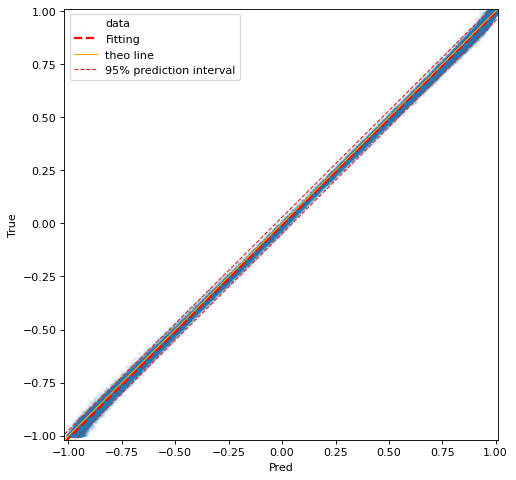

mean squared error = 3.8894268e-04


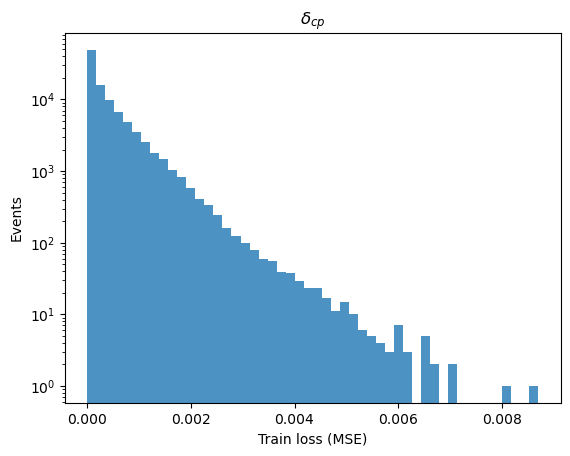

In [49]:
# sine prediction checking
analysis(x_val_pred_sin[:, 0], y_val_reg)

In [50]:
@njit(parallel=True, fastmath=True)
def kernel(array: np.ndarray, target: np.ndarray) -> tuple:
    """
    * theta1 is within [-pi/2, pi/2]; theta2 is out
    the previous range, but within [-pi, pi].
    * label(0) means the differences between predicted
    result and the truth label is within the inner
    range; the other label(1) refer to the outer range.
    """
    
    normalized_array = array.copy()
    for ind, ele in enumerate(array):
        if ele > 1:
            normalized_array[ind] = 1
        elif ele < -1:
            normalized_array[ind] = -1
            
    label = np.empty(len(normalized_array))
    theta1 = np.empty(len(normalized_array))
    theta2 = np.empty(len(normalized_array))
    # because the domain is differet and owing to the sine, it will differ with a negtive sign.
    for ind, (i, j) in enumerate(zip(normalized_array, target)):
        theta = -np.arcsin(i)
        if theta >= 0:
            theta1[ind], theta2[ind] = theta, np.pi - theta
        else:
            theta1[ind], theta2[ind] = theta, -np.pi - theta
        if np.abs(j - theta1[ind]) <= np.abs(j - theta2[ind]):
            label[ind] = 0
        else:
            label[ind] = 1
    print("Finish labeling...")
    return label, theta1, theta2

In [51]:
label, theta1, theta2 = kernel(x_val_pred_sin[:, 0], y_val_cla)

Finish labeling...


/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/numba/core/typed_passes.py:334: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../../var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_8631/554405019.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


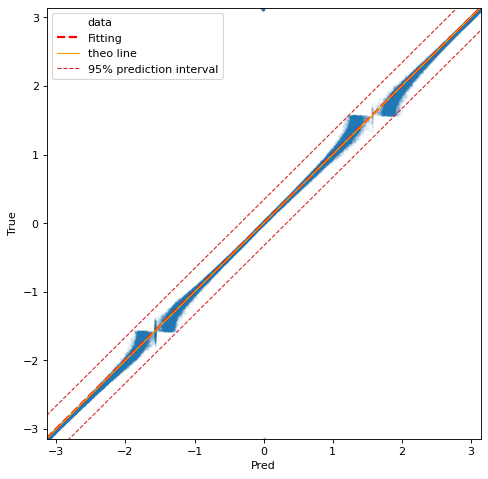

mean squared error = 2.9218824e-02


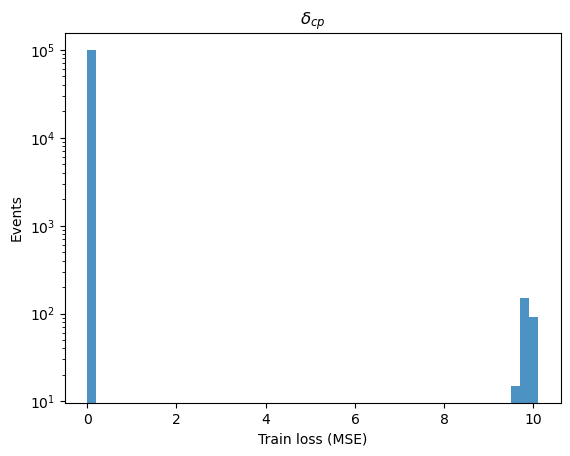

In [52]:
# delta prediction checking

if len(theta1) != len(theta2):
    raise ValueError("theta1 and theta2 must be the same length")

@njit(parallel=False)
def angle_decision(theta1, theta2):
    pred_ang = np.empty(len(theta1))
    for i in range(len(pred_ang)):
        if label[i] == 0:
            pred_ang[i] = theta1[i]
        else:
            pred_ang[i] = theta2[i]
    
    return pred_ang

pred_ang = angle_decision(theta1, theta2)
# because the domain is differet and owing to the sine, it will differ witha negtive sign.
analysis(pred_ang, y_val_cla)